## Is North America warming up?

Authors: Kevin Chang, Bharati Malik, Hariz Mohd Rani Hisham, Ritumbhra Sagar

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 12,10

import time
import os
import psycopg2

import os, sys
module_path = os.path.abspath(os.path.join('modules/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import testing
import regression

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 12,10

##### Define Create Connection function

In [3]:
'''
arg should ideally be a config() file.
'''
def create_connection():
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    import psycopg2
    conn = None
    try:
        conn = psycopg2.connect(host="sanjose",
                        database="atlas",
                        user="student"
                       )
        if conn != None:
            print('Connection to database successful.')
        return conn
    except:
        logging.warning('unable to connect to database')
        exit(1)
 
    return conn


In [4]:
conn = create_connection()
df = pd.read_sql_query('''SELECT region, 
                                    CONCAT(CONCAT(EXTRACT(YEAR from date),'-',EXTRACT(MONTH from date)),'-','01') as timestamp,
                                    AVG(min_temp) as min_temp
                           FROM student_weather 
                           GROUP BY region, CONCAT(CONCAT(EXTRACT(YEAR from date),'-',EXTRACT(MONTH from date)),'-','01')
                           LIMIT 20000;
                       ''', 
                      conn)
if conn is not None:
    conn.close()

Connection to database successful.


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
df.sort_values(by=['region','timestamp'],inplace=True)

## Q1

<img src="map.png" width="500"/>

This map was created using the average maximum of minimum temperatures across the US.

We took the daily maximum of min temperatures for given regions, and took an average temperature between those regions, across 1949-2010.

Note that the Mexico region is included in this data, despite not showing on the map above.

<img src="range.png" width="500"/>

For the visualization above, we took the difference between the average maximum and minimum temperatures for a given region.

Note that the above viz includes only selected regions, and also includes the Mexico region

## Q2

Longitudinal and latitudinal data

In [7]:
# Create connection
conn = create_connection()
# The SQL query
df = pd.read_sql_query('''SELECT region, CONCAT(latitude,'_',longitude) as coord,
                                    EXTRACT(YEAR FROM date) as year, 
                                    EXTRACT(MONTH FROM date) as month,
                                    AVG(min_temp) as min_temp, AVG(precipitation) as precip,
                                    AVG(wind) as wind
                          FROM student_weather
                          WHERE CONCAT(latitude,'_',longitude) IN (
                                  SELECT CONCAT(latitude,'_',longitude) as coord
                                    FROM student_weather
                                    WHERE region NOT IN ('mex')
                                    ORDER BY random()
                                    LIMIT 10)
                          GROUP BY 1,2,3,4
                       ''', 
                      conn)
# Closes connection if it exists
if conn is not None:
    conn.close()

Connection to database successful.


In [8]:
'''
args: pandas row

This function concatenates the year and month of a time series
record into a pandas datetime object.

returns:
'''
def combine_yr_mth(x):
    s = '-'  # delimiter of choice
    year = str(int(x['year']))
    month = str(int(x['month']))
    # If month is single digit, adds a '0' prefix
    if len(month) < 2:
        month = '0' + month
    # Temporary list. Uses .join() function to concatenate    
    date = [year,month,'01']
    timestamp = s.join(date)
    
    return timestamp

In [9]:
# Create a timestamp column to be used as the index
df['timestamp'] = pd.to_datetime(df.apply(lambda x : combine_yr_mth(x), axis=1))

In [10]:
'''
Custom module that loops through each region/coordinate, runs regression and residual diagnostics.

Returns the RMSE performance for in and out of sample, Durbin-Watson stat, and p-values for the 
time increment regressor.
'''
perf_in, perf_out, acorr_stat, pval = regression.regional_auto_ols(data=df,
                                                                   view='coord',
                                                                   lags=[1],
                                                                   show=False,
                                                                   diagnostics=False,
                                                                   monthly=True)

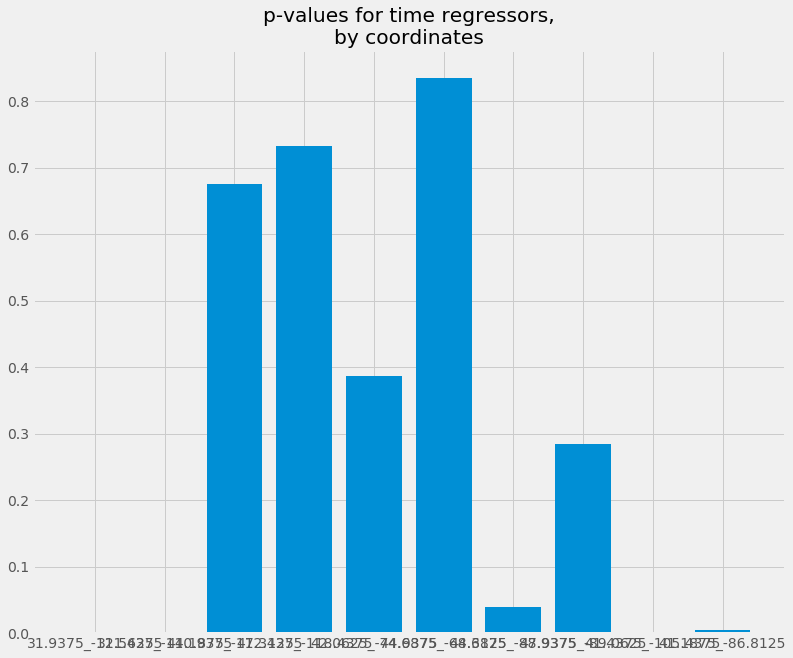

In [11]:
plt.bar(pval.keys(),pd.DataFrame(pval,range(len(pval))).iloc[0,:])
plt.title('p-values for time regressors,\nby coordinates')
plt.show()

Below, we extract a dataset containing average measurements across regions (which will also be used for national level data)

In [12]:
# Create connection
conn = create_connection()
# The SQL query
df = pd.read_sql_query('''SELECT region, EXTRACT(YEAR FROM date) AS year, 
                              EXTRACT(MONTH FROM date) AS month, AVG(min_temp) as min_temp,
                              AVG(precipitation) as precip, AVG(wind) as wind
                          FROM student_weather
                          WHERE region NOT IN ('mex')
                          GROUP BY 1,2,3;
                       ''', 
                      conn)
# Closes connection if it exists
if conn is not None:
    conn.close()

Connection to database successful.


In [13]:
# Create a timestamp column to be used as the index
df['timestamp'] = pd.to_datetime(df.apply(lambda x : combine_yr_mth(x), axis=1))

In [14]:
perf_in, perf_out, acorr_stat, pval = regression.regional_auto_ols(data=df,
                                                                   view='regional',
                                                                   lags=[1],
                                                                   show=False,
                                                                   diagnostics=False,
                                                                   monthly=True)

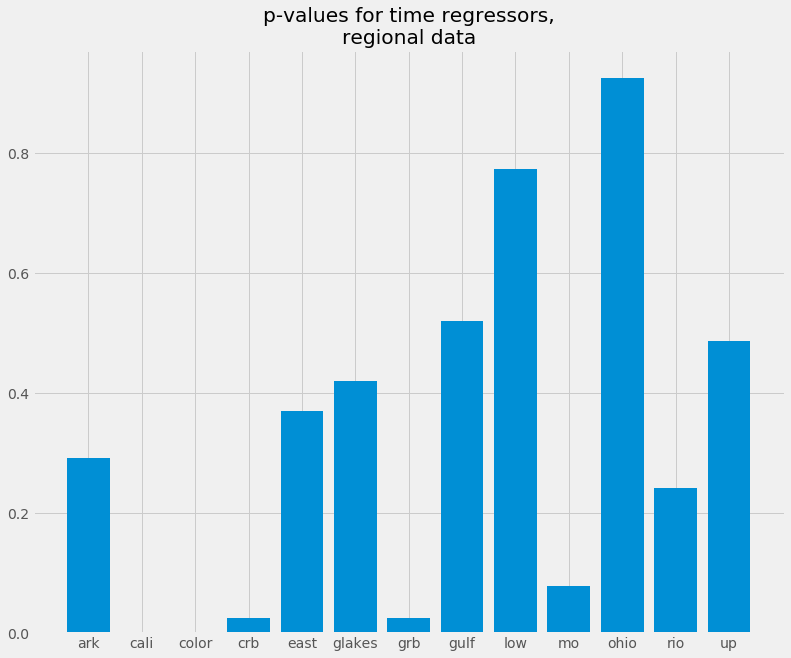

In [15]:
plt.bar(pval.keys(),pd.DataFrame(pval,range(len(pval))).iloc[0,:])
plt.title('p-values for time regressors,\nregional data')
plt.show()

National level data

In [16]:
# Create a timestamp column to be used as the index
df['timestamp'] = pd.to_datetime(df.apply(lambda x : combine_yr_mth(x), axis=1))
nat = pd.DataFrame(df.groupby(['timestamp'])['min_temp','precip','wind'].mean())

In [17]:
# Print first and last 5 rows
print('First 5 rows:\n')
print(nat.head(5))
print('\nLast 5 rows:\n')
print(nat.tail(5))

First 5 rows:

            min_temp     precip      wind
timestamp                                
1949-01-01 -8.641026  85.739787  3.610303
1949-02-01 -6.053709  61.783811  3.285554
1949-03-01 -1.118009  66.410196  3.473792
1949-04-01  3.804154  52.978680  3.081735
1949-05-01  9.142443  71.157806  2.843492

Last 5 rows:

             min_temp     precip      wind
timestamp                                 
2010-08-01  15.819061  60.937484  2.430257
2010-09-01  11.220024  69.318267  2.591728
2010-10-01   5.521230  49.228955  2.952935
2010-11-01  -1.045902  61.937666  3.507356
2010-12-01  -5.275600  66.246273  3.710872


#### Seasonal decomposition

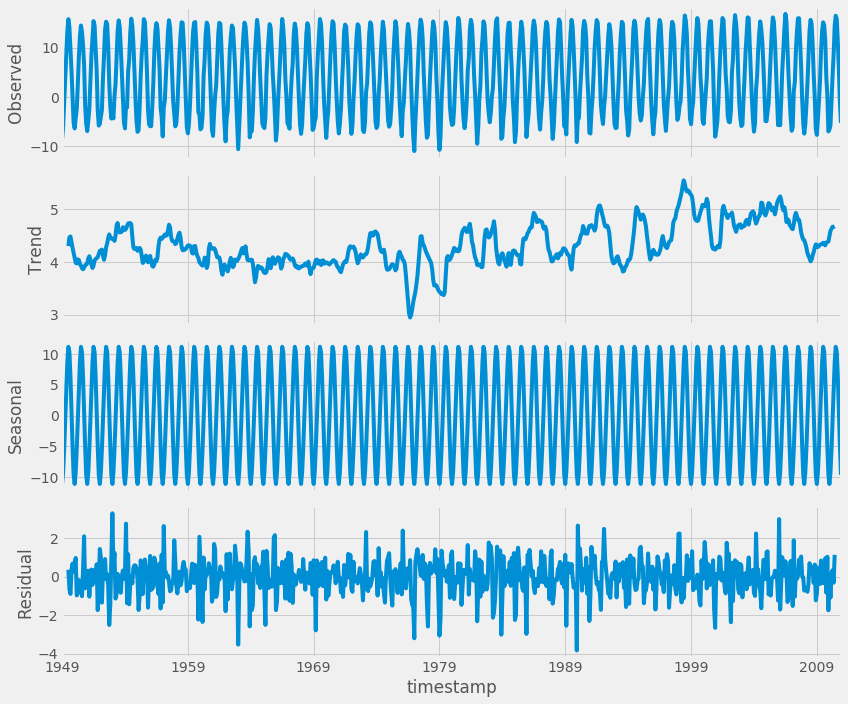

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(nat['min_temp'])
res.plot()
del res

plt.show()

- The trend component seems pretty interesting. It looks like the variance is getting bigger over time, and it takes longer to move the other way.
- Resiaulds don't really appear to be normal - requires further diagnostics.

#### Time Series Analysis of Raw Data

ADF Statistic: -4.285034
p-value: 0.000471
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569

We reject the Null Hypothesis (H0) -- the time series is stationary


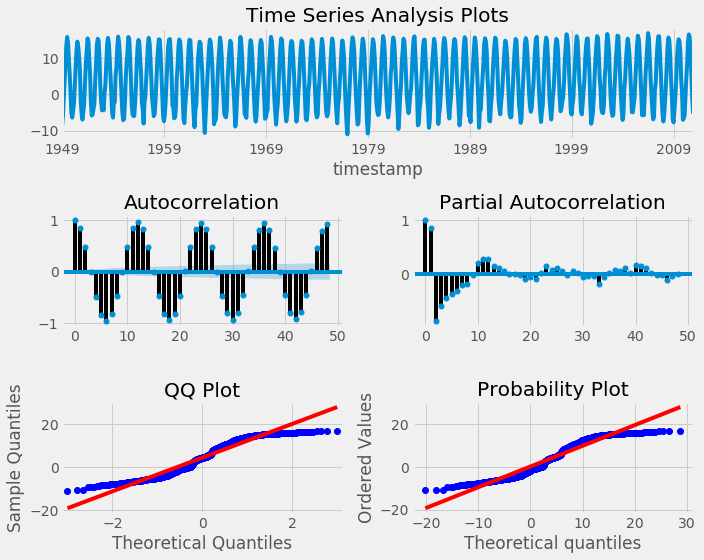

In [19]:
testing.ts_plot(nat['min_temp'],lags=48,style='fivethirtyeight')

#### Ljung-Box Test

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox
lb, p_values = ljungbox(nat['min_temp'],
                        lags = 48)

p_values

array([1.83203258e-119, 2.45339007e-156, 5.22182474e-155, 1.49326314e-192,
       2.96414234e-306, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

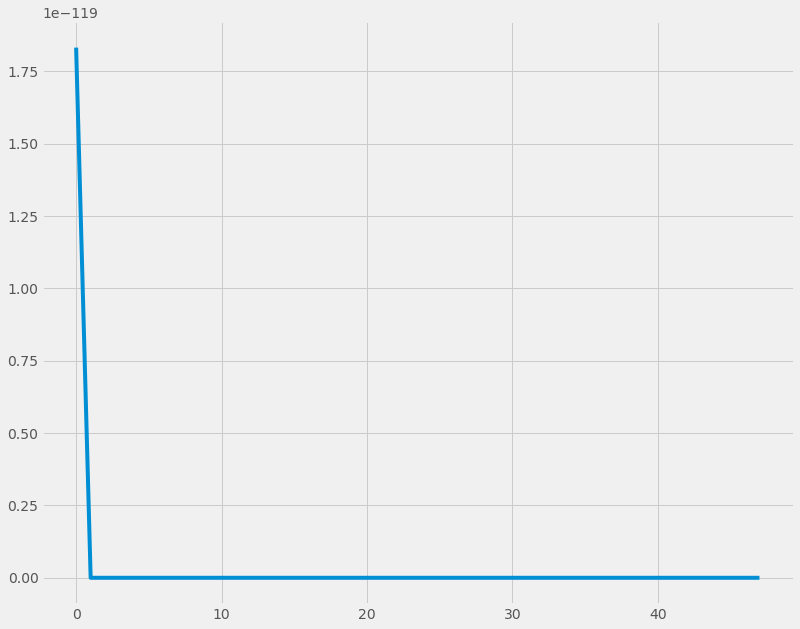

In [21]:
plt.plot(p_values)
plt.show()

- ADF stat indicates the time series is stationary
- PACF plot indicates some serial autocorrelation exists.
- significant p-vals of Ljung-Box test indiciates serial autocorrelation.

In [24]:
from sklearn.model_selection import train_test_split

# time index
e = []
for n,a in enumerate(nat['min_temp']):
    e += [n]

time_in = pd.DataFrame(e, columns=['Idx'])
nat_f = pd.concat([nat, time_in.set_index(nat.index)],axis=1)

# Introduce lags, since PACF above indicates a strong autocorrelation in L1
nat_f['L_1'] = pd.DataFrame(nat_f['min_temp']).shift(1)

# Select target and features. Wind and precip are excluded from features
y = list(nat_f['min_temp'][1:])
X = nat_f.iloc[1:,3:]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=False)

In [25]:
import statsmodels.api as sm # Time Series Analysis

reg = sm.OLS(y_train,
             X_train)
results = reg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.787
Model:                            OLS   Adj. R-squared (uncentered):              0.787
Method:                 Least Squares   F-statistic:                              1096.
Date:                Sat, 07 Dec 2019   Prob (F-statistic):                   9.50e-200
Time:                        12:06:16   Log-Likelihood:                         -1680.6
No. Observations:                 594   AIC:                                      3365.
Df Residuals:                     592   BIC:                                      3374.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Idx            0.0016      0.001      2.920      0.004       0.001       0.003
L_1            0.8624      0.021     41.356      0.000       0.821       0.903
==============================================================================
Omnibus:                      708.157   Durbin-Watson:                   0.506
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.362
Skew:                          -0.189   Prob(JB):                     3.84e-10
Kurtosis:                       1.731   Cond. No.                         42.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ADF Statistic: -1.527295
p-value: 0.519968
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569

We fail to reject the Null Hypothesis (H0) -- the time series has a unit root and is not stationary


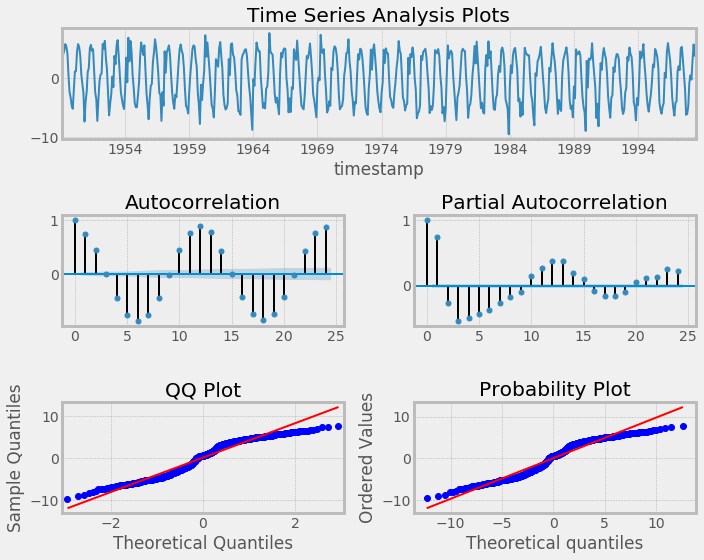

In [26]:
testing.ts_plot(results.resid, lags=24)

---------------
Monthly Min Temp
Lag 1
---------------


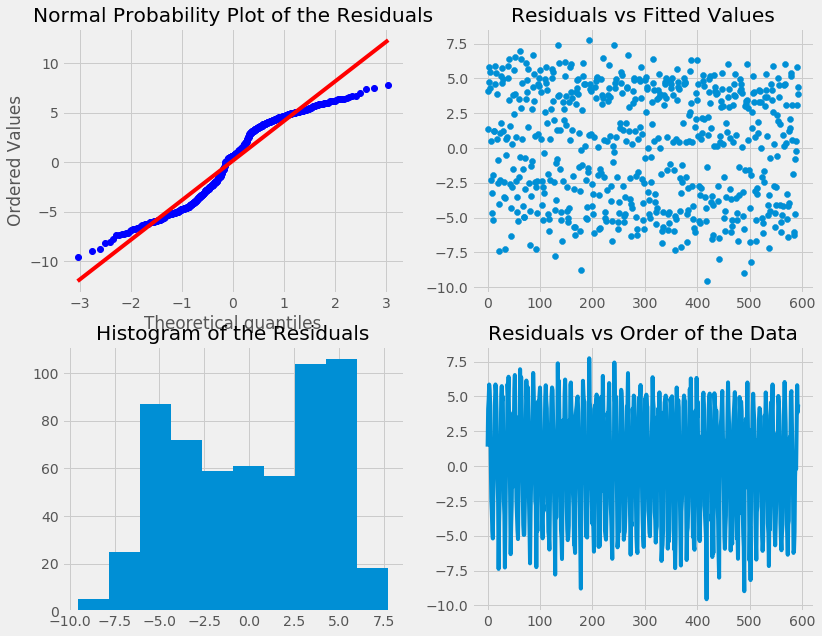

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [3.32832021e-074 5.48099751e-098 9.25738708e-097 2.07397631e-120
 7.15953730e-194 8.39724966e-293 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
PROBLEM!  There appears to be information left in the residuals


True

In [27]:
idx = list(range(len(y_train)))
y_hat = results.predict(X_train)

print('---------------\n%s\n---------------' % ('Monthly Min Temp\nLag 1'))
testing.eval_plot(idx, y_train, y_hat, lags=24)

From the above regression, we can't tell for sure if temperature has been increasing in any meaningful way when looking at the United States as a whole.

## Q3 Incorporating external data

In [218]:
ghg = pd.read_csv('C:/Users/mohdh/Downloads/greenhouse.csv')[:62].set_index('Year')

In [219]:
df['year'] = df['timestamp'].dt.year

In [220]:
ghg = pd.concat([df.groupby('year').mean().drop(columns=['month']),ghg],axis=1)

In [221]:
ghg.head(4)

min_temp     precip      wind    ghg_tonnes
1949  4.205198  63.855755  2.984279  8.927082e+10
1950  3.951412  65.506385  3.025209  9.180676e+10
1951  3.868572  64.714993  3.097886  9.441913e+10
1952  4.187452  55.082225  2.988777  9.696421e+10

In [225]:
# Introduce lags, since PACF above indicates a strong autocorrelation in L1
ghg['L_1'] = pd.DataFrame(ghg['min_temp']).shift(1)

# Select target and features. Wind and precip are excluded from features
y = list(ghg['min_temp'][1:])
X = ghg.iloc[1:,1:]

# Prepend a constant to the regressors
from statsmodels.tools.tools import add_constant
X = add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=False)

In [226]:
reg = sm.OLS(y_train,
             X_train)
ghg_results = reg.fit()
ghg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     3.050
Date:                Thu, 05 Dec 2019   Prob (F-statistic):             0.0268
Time:                        20:58:32   Log-Likelihood:                -11.849
No. Observations:                  48   AIC:                             33.70
Df Residuals:                      43   BIC:                             43.05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2671      2.361      3.501      0.001       3.505      13.029
precip         0.0229      0.011      2.158      0.037       0.001       0.044
wind          -1.9370      0.763     -2.538      0.015      -3.476      -0.398
ghg_tonnes  6.045e-13   9.27e-13      0.652      0.518   -1.27e-12    2.47e-12
L_1            0.0854      0.140      0.610      0.545      -0.197       0.368
==============================================================================
Omnibus:                        0.360   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.247
Skew:                          -0.170   Prob(JB):                        0.884
Kurtosis:                       2.907   Cond. No.                     9.69e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.69e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

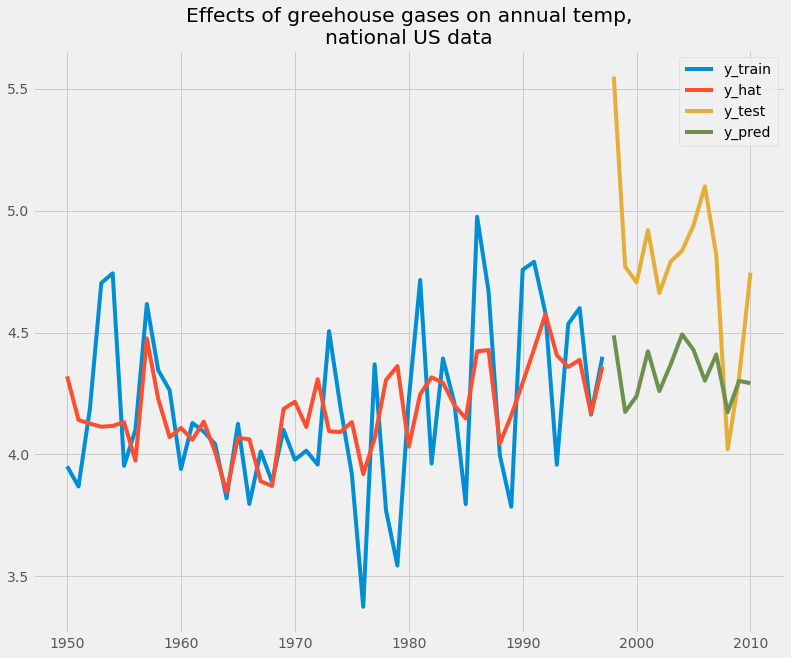

In [269]:
y_pred = ghg_results.predict(X_test)

plt.plot(ghg[1:len(y_train)+1].index, y_train, label='y_train')
plt.plot(ghg_results.fittedvalues, label='y_hat')
plt.plot(ghg[len(y_train)+1:].index, y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.title('Effects of greehouse gases on annual temp,\nnational US data')
plt.legend()
plt.show()

In [309]:
s = '-'
p = []
for i in ghg_results.fittedvalues.index:
    p += [s.join([str(i),'12','01'])]
    
p = pd.DataFrame(p,columns=['timestamp'])
p = pd.to_datetime(p['timestamp'])

In [310]:
p = pd.concat([ghg_results.fittedvalues.reset_index(drop=True),p], ignore_index = True, axis=1)\
        .rename(columns={0:'val',1:'timestamp'}).set_index('timestamp')

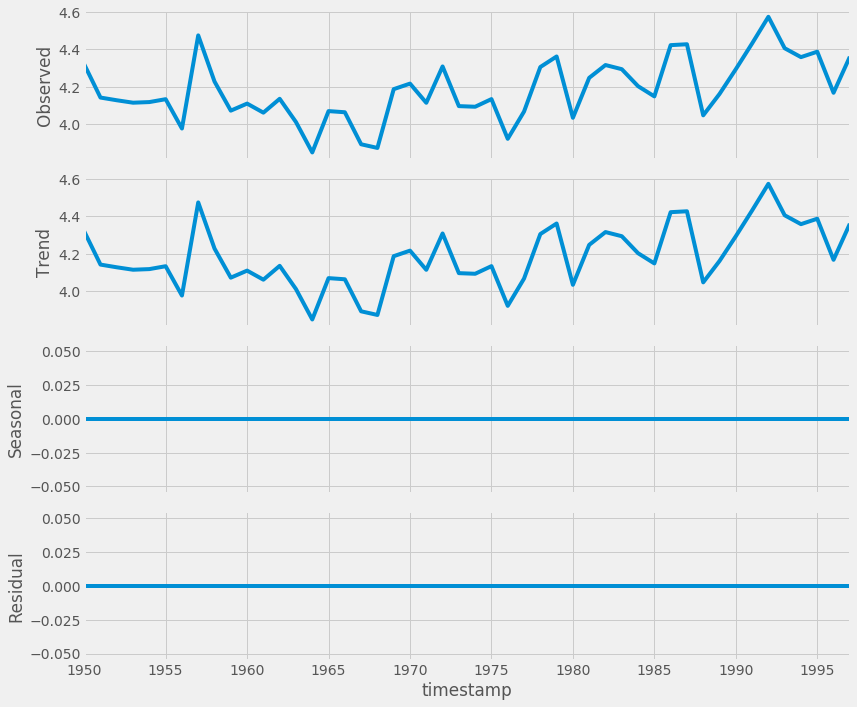

In [311]:
res = seasonal_decompose(p)
res.plot()
del res

plt.show()

## Q4 Are meteorological effects becoming more volatile?

Below, we inspect the volatility of average precipitation across the US:

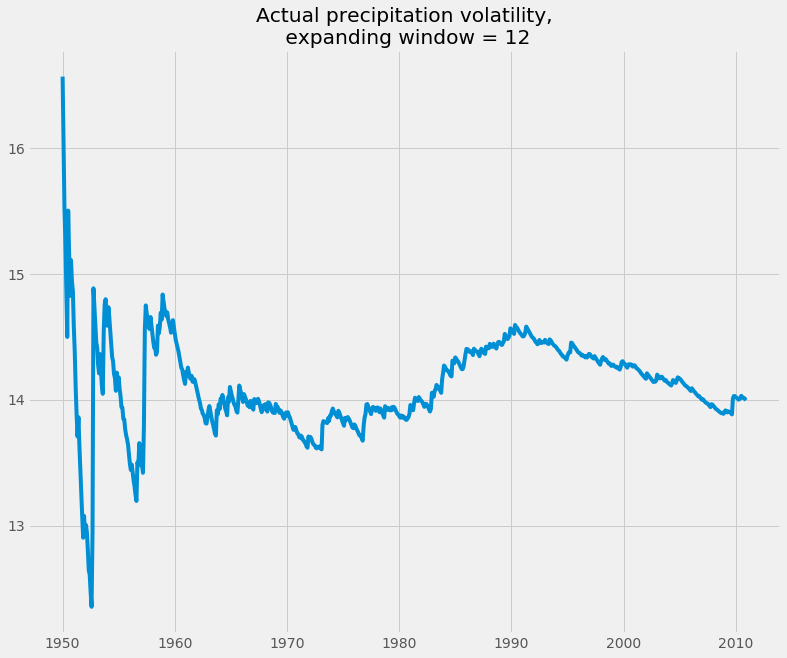

In [28]:
window = 12
nat['precip_vol'] = nat['precip'].expanding(min_periods=window).std(ddof=0)

plt.plot(nat['precip_vol'][window:])
plt.title('Actual precipitation volatility,\n expanding window = %s' % window)
plt.show()

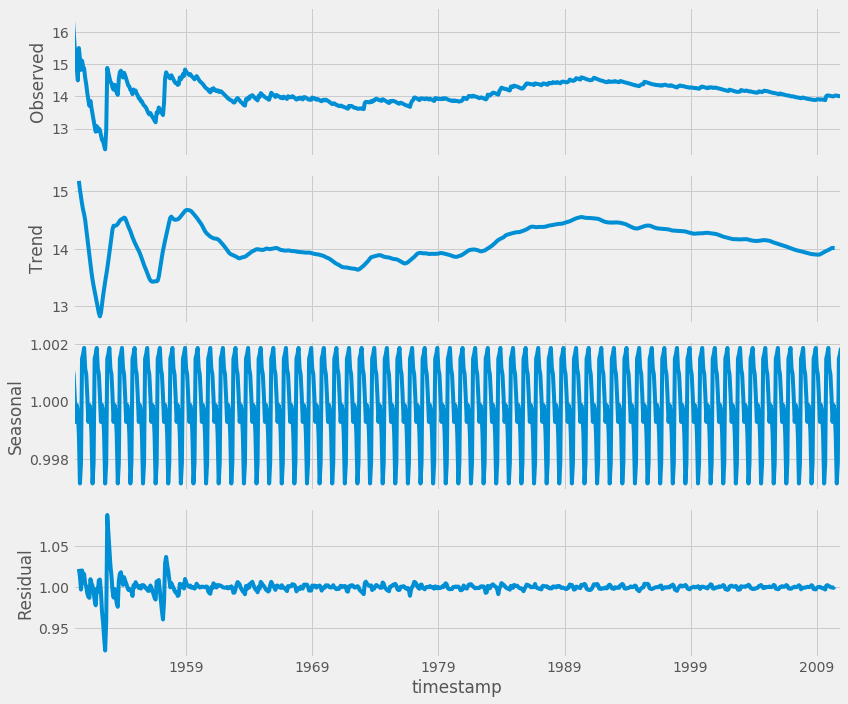

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(nat['precip_vol'][window:], model='mul')
res.plot()
del res

plt.show()

After controlling for seasonality in volatility, it looks like there's a clear upwards trend in the volatility of windspeeds across the US.

We can do the same check for average wind speeds as well.

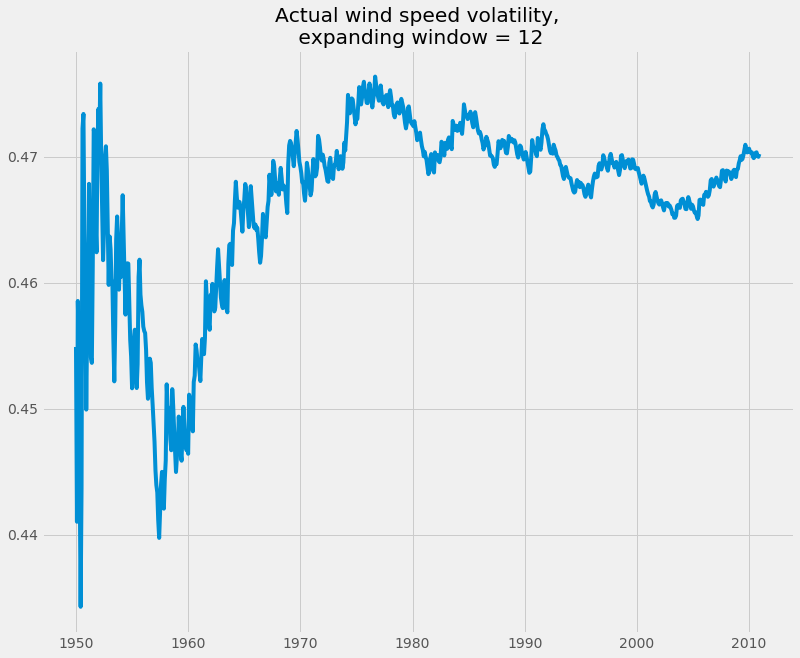

In [30]:
nat['wind_vol'] = nat['wind'].expanding(min_periods=window).std(ddof=0)

plt.plot(nat['wind_vol'][window:])
plt.title('Actual wind speed volatility,\n expanding window = %s' % window)
plt.show()

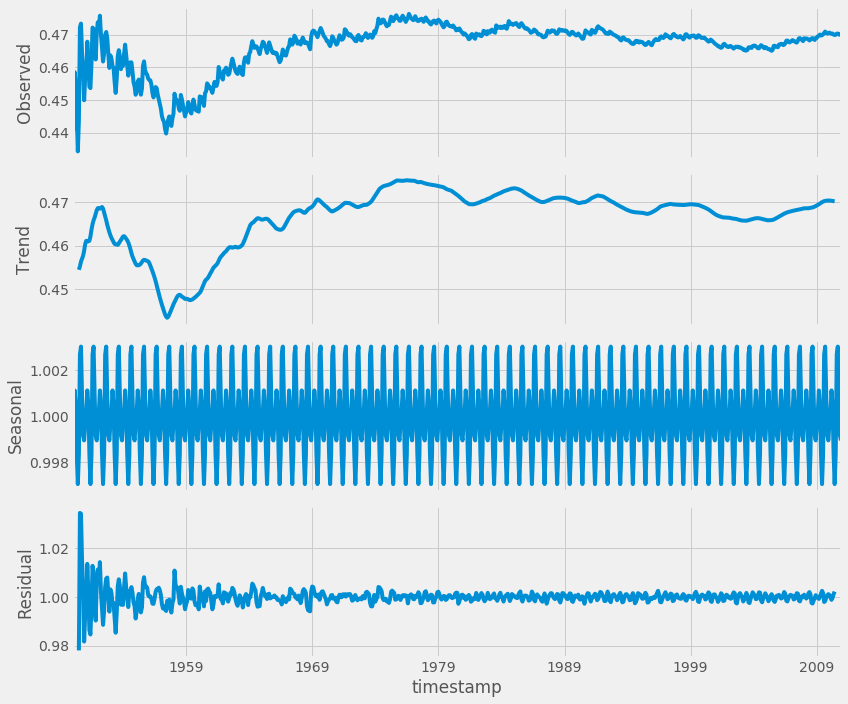

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(nat['wind_vol'][window:], model='mul')
res.plot()
del res

plt.show()

However, we can't say the same about precipitation when we look at US national data as a whole.

Perhaps we can have a clearer view when looking at individual regions. Let's look at California below:

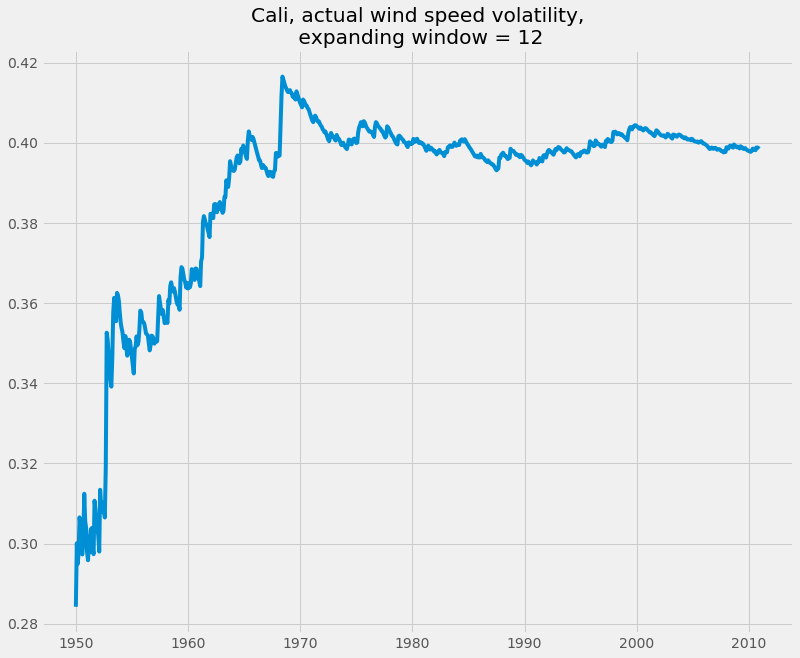

In [32]:
cali = df[df['region'] == 'cali'].set_index('timestamp').drop(columns=['year',
                                                                        'month'])

cali['wind_vol'] = cali['wind'].expanding(min_periods=window).std(ddof=0)

plt.plot(cali['wind_vol'][window:])
plt.title('Cali, actual wind speed volatility,\n expanding window = %s' % window)
plt.show()

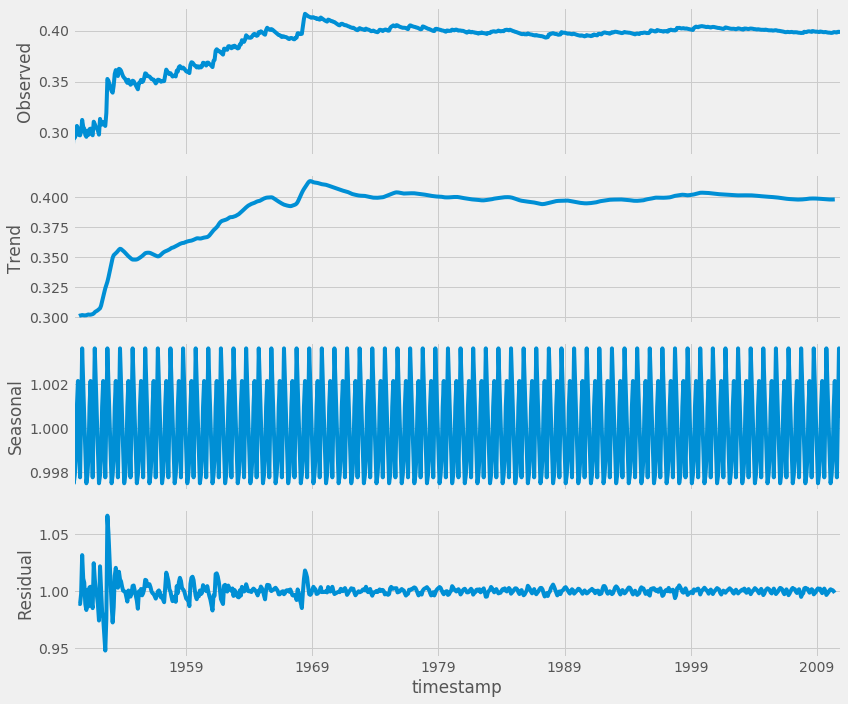

In [33]:
res = seasonal_decompose(cali['wind_vol'][window:], model='mul')
res.plot()
del res

plt.show()

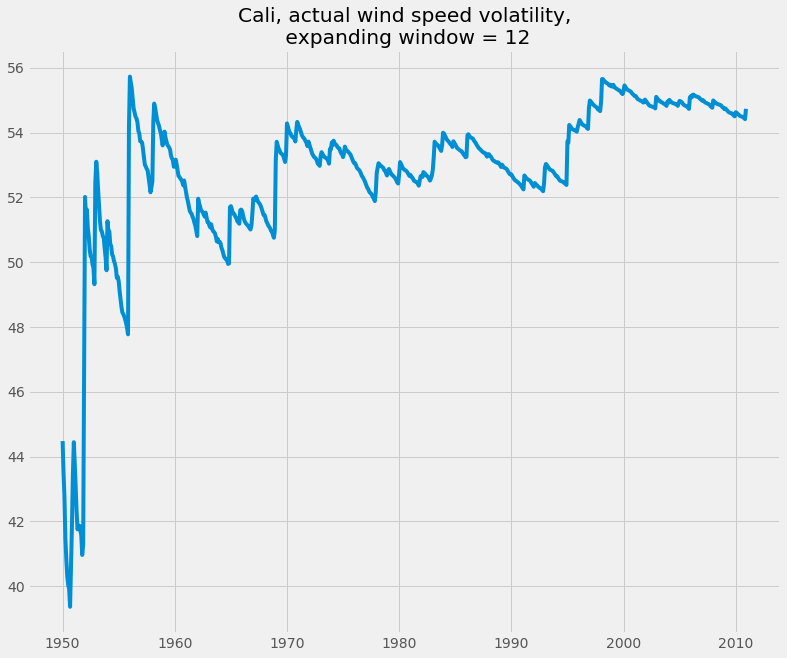

In [34]:
cali['precip_vol'] = cali['precip'].expanding(min_periods=window).std(ddof=0)

plt.plot(cali['precip_vol'][window:])
plt.title('Cali, actual wind speed volatility,\n expanding window = %s' % window)
plt.show()

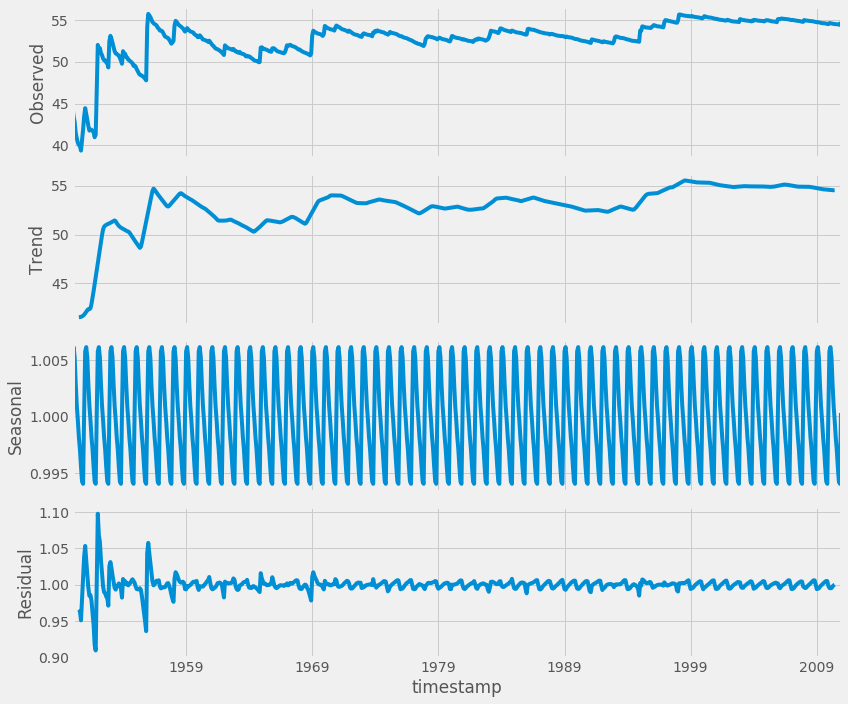

In [35]:
res = seasonal_decompose(cali['precip_vol'][window:], model='mul')
res.plot()
del res

plt.show()

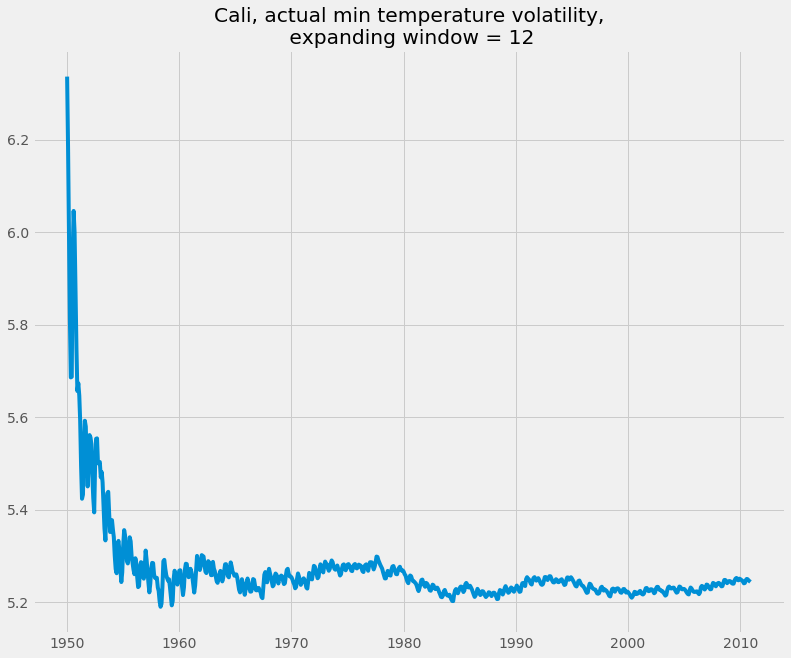

In [36]:
cali['temp_vol'] = cali['min_temp'].expanding(min_periods=window).std(ddof=0)

plt.plot(cali['temp_vol'][window:])
plt.title('Cali, actual min temperature volatility,\n expanding window = %s' % window)
plt.show()

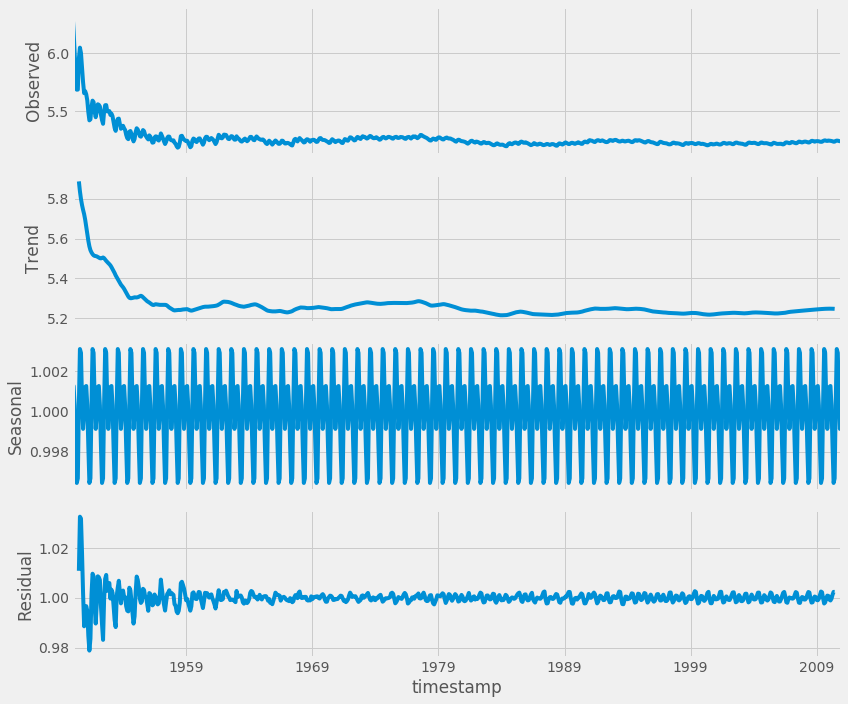

In [37]:
res = seasonal_decompose(cali['temp_vol'][window:], model='mul')
res.plot()
del res

plt.show()

Surprisingly, while windspeed and precipitation volatility seem to be increasing, minimum temperature volatility in the California region has been on an overall decline. 

However, a decline in volatility isn't necessary a good thing - we may just be trending upwards to a new normal of hotter climate!

## Q5

#### OLS Model - National, monthly average minimum temperature

Since the data is obviously seasonal, we will introduce monthly regressors to capture seasonal effects of temperature across months

In [39]:
cali = cali.drop(columns=['wind_vol','precip_vol','temp_vol'])

In [42]:
# [1,count,j,f,m,a,m,j,j,a,s,o,n,d]
M = []
for n,(d,p) in enumerate(cali['min_temp'].items()):
    m = [1, n] + [0] * 12
    m[d.month+1] = 1
    M += [m]
# inspect
M[:4]

monthly = pd.DataFrame(M, columns=['1','count','j','f','m','a','m','j','j','a','s','o','n','d'])
nat_f = pd.concat([cali, monthly.set_index(nat.index)],axis=1)

Introducing lag 1, lag 2, lag 6, lag 12, lag 24

ADF Statistic: -5.046837
p-value: 0.000018
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569

We reject the Null Hypothesis (H0) -- the time series is stationary


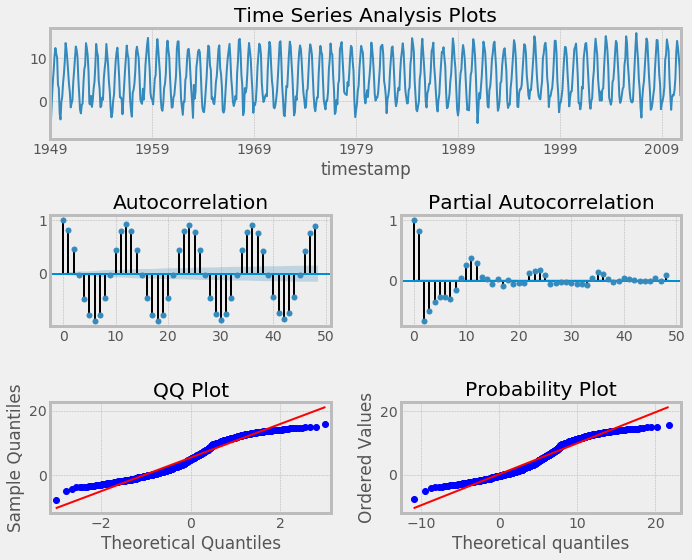

In [43]:
testing.ts_plot(nat_f['min_temp'], lags=48)

In [49]:
# Introduce lags, since PACF above indicates a strong autocorrelation in L1
nat_f['L_1'] = pd.DataFrame(nat_f['min_temp']).shift(1)

# Select target and features. Wind and precip are excluded from features
y = list(nat_f['min_temp'][1:])
X = nat_f.iloc[1:,2:].drop(columns=['precip','wind'])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=False)

In [52]:
reg = sm.OLS(y_train,
             X_train)
ols_results = reg.fit()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     826.4
Date:                Sat, 07 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:12:39   Log-Likelihood:                -939.34
No. Observations:                 594   AIC:                             1907.
Df Residuals:                     580   BIC:                             1968.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1              3.4756      0.195     17.801      0.000       3.092       3.859
count          0.0014      0.000      4.635      0.000       0.001       0.002
j             -4.9973      0.292    -17.117      0.000      -5.571      -4.424
f             -3.4543      0.301    -11.479      0.000      -4.045      -2.863
m             -2.3692      0.250     -9.493      0.000      -2.859      -1.879
a             -0.4668      0.210     -2.226      0.026      -0.879      -0.055
m              2.2952      0.168     13.667      0.000       1.965       2.625
j              5.0127      0.181     27.685      0.000       4.657       5.368
j              7.0559      0.270     26.089      0.000       6.525       7.587
a              5.8929      0.365     16.158      0.000       5.177       6.609
s              3.4543      0.344     10.037      0.000       2.778       4.130
o             -0.1055      0.259     -0.408      0.684      -0.614       0.403
n             -3.4228      0.167    -20.452      0.000      -3.752      -3.094
d             -5.4193      0.207    -26.154      0.000      -5.826      -5.012
L_1            0.2092      0.040      5.256      0.000       0.131       0.287
==============================================================================
Omnibus:                        1.001   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.606   Jarque-Bera (JB):                0.835
Skew:                           0.075   Prob(JB):                        0.659
Kurtosis:                       3.106   Cond. No.                     3.06e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.48e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

ADF Statistic: -24.669373
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569

We reject the Null Hypothesis (H0) -- the time series is stationary


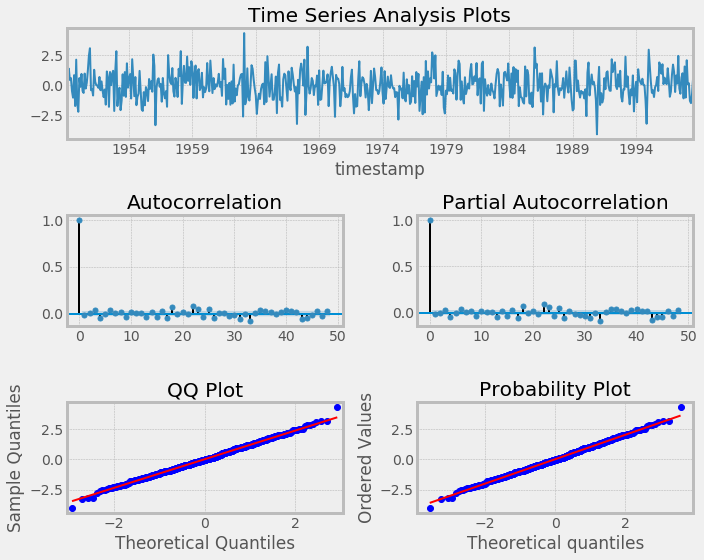

In [53]:
testing.ts_plot(ols_results.resid, lags=48)

---------------
Monthly Min Temp
Lag 1
---------------


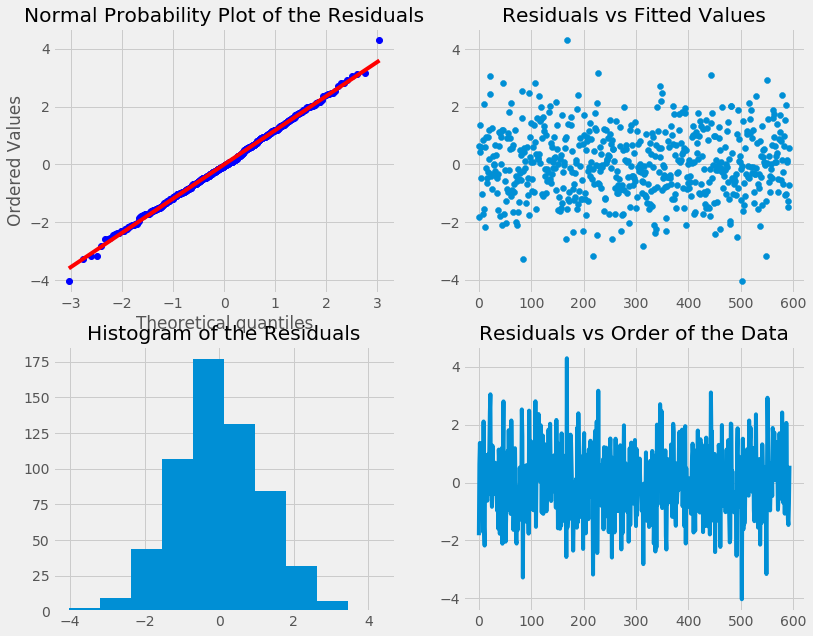

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.75386518 0.95178513 0.85801762 0.76534919 0.86829695 0.8338458
 0.90294133 0.93703626 0.92719674 0.94811466 0.96982111 0.98304497
 0.97396196 0.98256575 0.98059419 0.98271615 0.96369736 0.89379695
 0.92323606 0.94201444 0.95914113 0.83056709 0.78967001 0.80068002]
There does not appear to be information left in the residuals


False

In [54]:
idx = list(range(len(y_train)))
y_hat = ols_results.predict(X_train)

print('---------------\n%s\n---------------' % ('Monthly Min Temp\nLag 1'))
testing.eval_plot(idx, y_train, y_hat, lags=24)

In [55]:
perf_in = {}
perf_in['OLS_L1'] = testing.measure_error(y_train, y_hat, label='OLS L_1 Regressors',show=False)

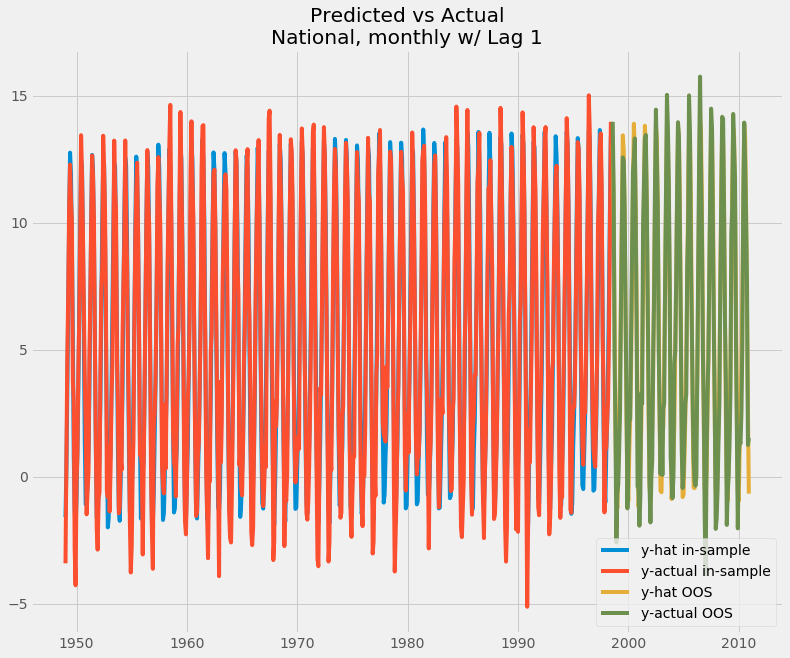

In [56]:
y_pred = ols_results.predict(X_test)

plt.plot(list(nat_f[:len(y_train)].index), y_hat, label = 'y-hat in-sample')
plt.plot(list(nat_f[:len(y_train)].index), y_train, label = 'y-actual in-sample')
plt.plot(list(nat_f[len(y_train)+1:].index),y_pred, label = 'y-hat OOS')
plt.plot(list(nat_f[len(y_train)+1:].index), y_test, label = 'y-actual OOS')

perf_out = {}
perf_out['OLS_L1'] = testing.measure_error(y_test, y_pred, label='OLS L_1 Regressors',show=False)

plt.title('Predicted vs Actual\nNational, monthly w/ Lag 1')
plt.legend()
plt.show()

### Holt-Winters

In [112]:
# Take a log (x + 100) to handle non-positive numbers
# Will require undo of transform after model fitting
y = list(np.log(nat_f['min_temp'] + 100))

y_train, y_test = train_test_split(y,
                                   test_size=0.2,
                                   random_state=42,
                                   shuffle=False)

In [116]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw = ExponentialSmoothing(np.array(y_train),trend=None,seasonal='add',seasonal_periods=12)
fit_hw = hw.fit()

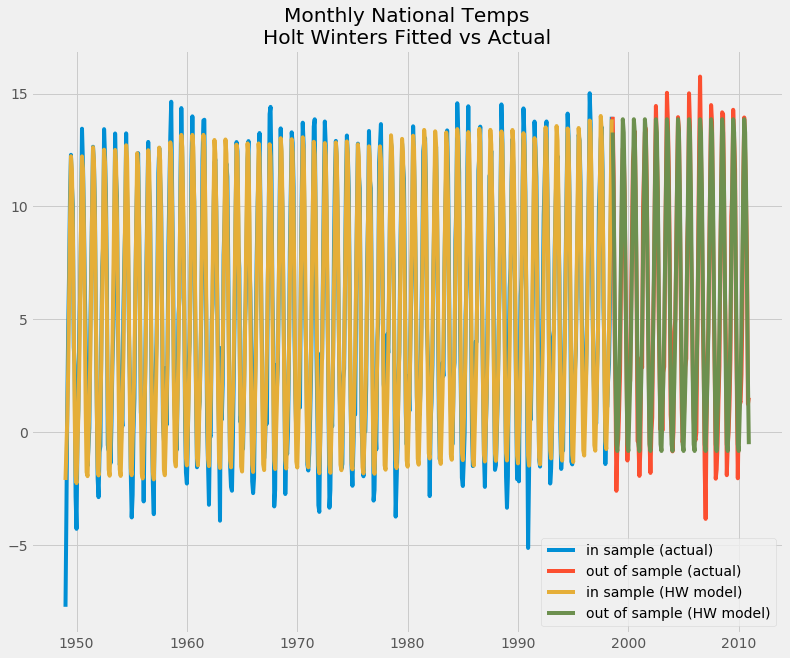

In [117]:
'''
Code adapted from Dan Trepanier, lecture 5.0 Smoothing
'''

IND = {'in':list(nat_f[:len(y_train)].index), 'out': list(nat_f[len(y_train):].index)}

HW = {'in': list(np.exp(fit_hw.fittedvalues)-100),
      'out': list(np.exp(fit_hw.forecast(len(y_test)))-100)}

plt.plot(IND['in'], np.exp(y_train) - 100, label='in sample (actual)')
plt.plot(IND['out'], np.exp(y_test) - 100, label='out of sample (actual)')

plt.plot(IND['in'], HW['in'], label='in sample (HW model)')
plt.plot(IND['out'], HW['out'], label='out of sample (HW model)')

plt.legend()
plt.title('Monthly National Temps\nHolt Winters Fitted vs Actual')
plt.show()

In [118]:
from sklearn.metrics import mean_squared_error
import statistics
import math

rmse1_in = math.sqrt(mean_squared_error(np.exp(y_train) - 100, HW['in']))
rmse1_in_pct = rmse1_in / statistics.mean(np.exp(y_train) - 100)

rmse1_out = math.sqrt(mean_squared_error(np.exp(y_test) - 100, HW['out']))
rmse1_out_pct = rmse1_out / statistics.mean(np.exp(y_test) - 100)

In [119]:
perf_in['Holt-Winters'] = testing.measure_error(np.exp(y_train) - 100, HW['in'], label='Holt-Winters Monthly', show = False)
perf_out['Holt-Winters'] = testing.measure_error(np.exp(y_test) - 100, HW['out'], label='Holt-Winters Monthly', show = False)

### ARMA

In [122]:
nat_f.head(3)

region  min_temp      precip      wind  1  count  j  f  m  a  m  j  \
timestamp                                                                       
1949-01-01   cali -7.732440   47.621294  2.668376  1      0  1  0  0  0  0  0   
1949-02-01   cali -3.415953   74.521755  2.216352  1      1  0  1  0  0  0  0   
1949-03-01   cali  1.029191  111.220403  2.935458  1      2  0  0  1  0  0  0   

            j  a  s  o  n  d       L_1  
timestamp                               
1949-01-01  0  0  0  0  0  0       NaN  
1949-02-01  0  0  0  0  0  0 -7.732440  
1949-03-01  0  0  0  0  0  0 -3.415953

In [123]:
y = list(nat_f['min_temp'])
X = nat_f.iloc[:,2:4]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                     y,
                                                     test_size=0.2,
                                                     random_state=42,
                                                     shuffle=False)

In [124]:
from pmdarima.arima import auto_arima

sarima_model = auto_arima(y_train,
                          exogenous=X_train,
                           start_p=0,
                           start_q=0,
                           max_p=3,
                           max_q=3,
                           start_P=0,
                           start_Q=0,
                           max_P=3,
                           max_Q=3,
                           m=12, 
                           seasonal=True,
                           trace=True,
                           stepwise=True,
                           d=0,
                           D=0,
                           error_action='ignore',
                           suppress_warnings=True,
                           random_state = 42,
                           n_fits=20
                         )

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=3385.505, BIC=3403.059, Fit time=0.430 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=2157.189, BIC=2183.521, Fit time=3.340 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=2757.794, BIC=2784.125, Fit time=3.281 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=2915.800, BIC=2937.743, Fit time=0.772 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=2028.422, BIC=2059.142, Fit time=11.263 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=1964.517, BIC=1999.626, Fit time=11.370 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(3, 0, 2, 12); AIC=1892.537, BIC=1936.423, Fit time=35.451 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(3, 0, 2, 12); AIC=1965.473, BIC=2004.970, Fit time=28.161 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(3, 0, 2, 12); AIC=1873.544, BIC=1921.818, Fit time=39.856 seconds
Fit ARIMA: order=(2, 0,

In [125]:
sarima_model.order, sarima_model.seasonal_order
model_specs = 'SARIMA%sx%s' % (str(sarima_model.order), str(sarima_model.seasonal_order))
print(model_specs)

SARIMA(2, 0, 0)x(3, 0, 2, 12)


In [126]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  595
Model:             SARIMAX(2, 0, 0)x(3, 0, 2, 12)   Log Likelihood                -925.772
Date:                            Sat, 07 Dec 2019   AIC                           1873.544
Time:                                    18:53:19   BIC                           1921.818
Sample:                                         0   HQIC                          1892.343
                                            - 595                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0322      0.023      1.374      0.169      -0.014       0.078
x1             0.0104      0.001      9.601      0.000       0.008       0.013
x2            -2.3544      0.186    -12.668      0.000      -2.719      -1.990
ar.L1          0.2918      0.041      7.185      0.000       0.212       0.371
ar.L2          0.0656      0.040      1.635      0.102      -0.013       0.144
ar.S.L12       0.0371      1.092      0.034      0.973      -2.104       2.178
ar.S.L24       0.9106      1.002      0.909      0.363      -1.053       2.874
ar.S.L36       0.0477      0.101      0.474      0.636      -0.150       0.245
ma.S.L12       0.0861      1.088      0.079      0.937      -2.047       2.219
ma.S.L24      -0.7379      0.880     -0.839      0.402      -2.462       0.987
sigma2         1.2487      0.066     18.930      0.000       1.119       1.378
===================================================================================
Ljung-Box (Q):                       52.90   Jarque-Bera (JB):                19.53
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.00
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
sarima_model.fit(y_train, exogenous=X_train)
y_hat, conf_int_in = sarima_model.predict_in_sample(exogenous=X_train, return_conf_int=True)

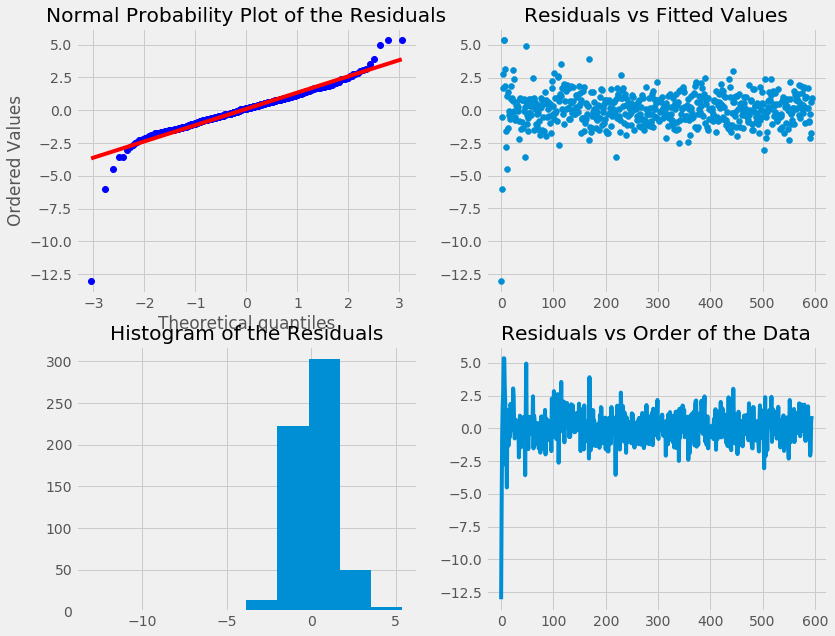

Ljung-Box Test
H_0 (p>0.05) --> The data are independently distributed -- i.e. there's no auto correlations
H_a (p<0.05) --> The data are not independently distributed -- i.e. there is auto correlations
p_values [0.00349697 0.01404385 0.03269256 0.00476935 0.00049254 0.00060381
 0.00130762 0.00243667 0.00340909 0.00352789 0.00265343 0.00329557
 0.00536199 0.0081347  0.01266937 0.00183662 0.00287069 0.00397361
 0.0060814  0.0076654 ]
PROBLEM!  There appears to be information left in the residuals


In [133]:
N_in = list(range(len(y_train)))
testing.eval_plot(N_in, y_train, y_hat)
perf_in[model_specs] = testing.measure_error(y_train, y_hat, label=model_specs, show=False)

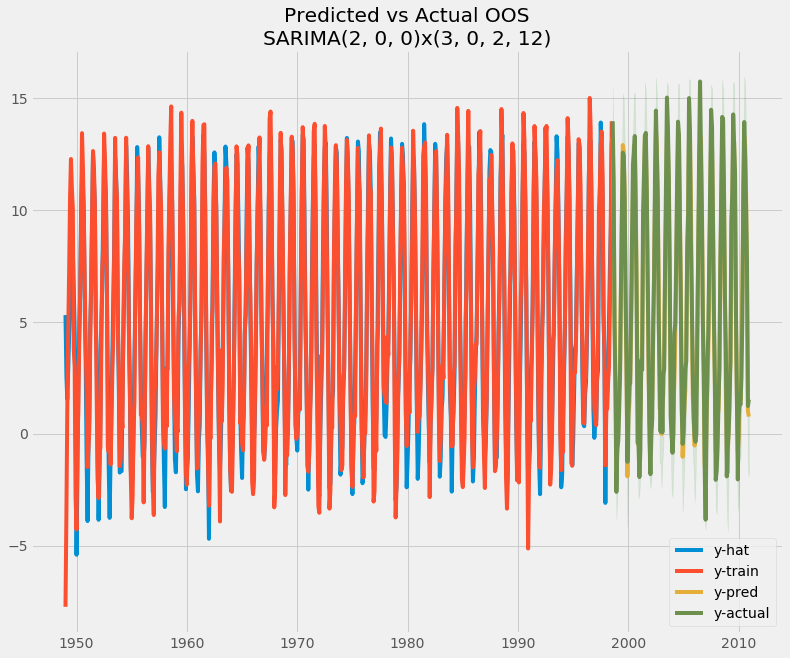

In [134]:
future_forecast, conf_int = sarima_model.predict(n_periods=len(y_test), exogenous=X_test, return_conf_int=True)
future_forecast = pd.DataFrame(future_forecast, index=nat_f.index[len(y_train):], columns=['Prediction'])

future_forecast['Actual'] = y_test

plt.plot(np.array(nat_f.index[:len(y_train)]), y_hat, label = 'y-hat')
plt.plot(np.array(nat_f.index[:len(y_train)]), y_train, label = 'y-train')
plt.plot(future_forecast['Prediction'], label = 'y-pred')
plt.plot(np.array(future_forecast.index), future_forecast['Actual'], label = 'y-actual')
plt.fill_between(np.array(future_forecast.index),
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='g')
plt.title('Predicted vs Actual OOS\n%s' % model_specs)
plt.legend()
plt.show()

perf_out[model_specs] = testing.measure_error(y_test, np.array(future_forecast['Prediction']), label=model_specs, show=False)

In [135]:
pd.DataFrame(perf_in)

OLS_L1          Holt-Winters  \
label       OLS L_1 Regressors  Holt-Winters Monthly   
RMSE                   1.17638               1.23446   
RMSE_pcent            0.222872              0.234849   

            SARIMA(2, 0, 0)x(3, 0, 2, 12)  
label       SARIMA(2, 0, 0)x(3, 0, 2, 12)  
RMSE                              1.31605  
RMSE_pcent                        0.25037

In [136]:
pd.DataFrame(perf_out)

OLS_L1          Holt-Winters  \
label       OLS L_1 Regressors  Holt-Winters Monthly   
RMSE                   1.08679               1.09481   
RMSE_pcent            0.187359              0.188741   

            SARIMA(2, 0, 0)x(3, 0, 2, 12)  
label       SARIMA(2, 0, 0)x(3, 0, 2, 12)  
RMSE                              1.00275  
RMSE_pcent                        0.17287

#### Model comparison

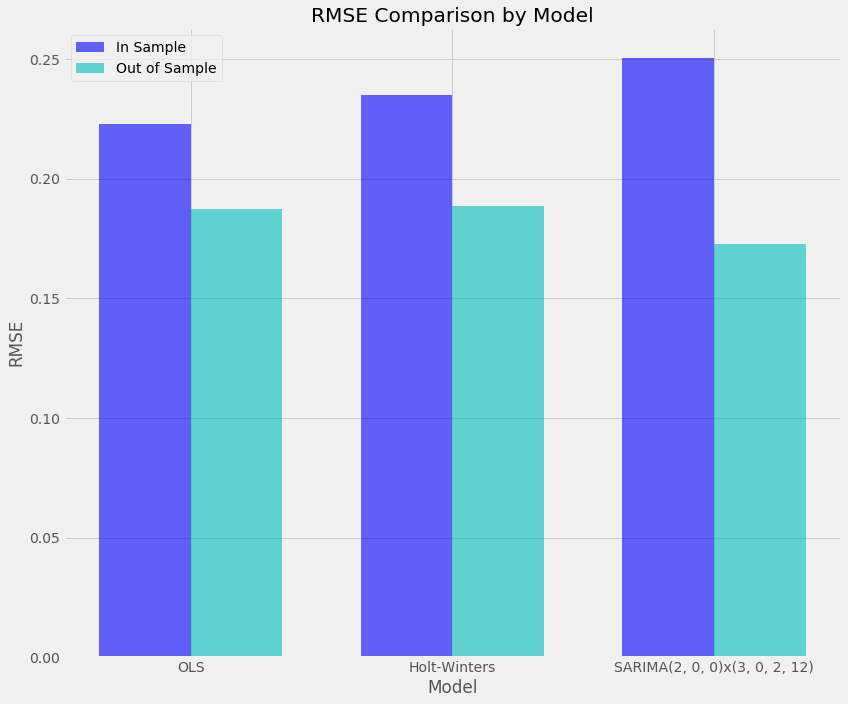

In [137]:
'''
Adapted from https://pythonspot.com/matplotlib-bar-chart/
'''
fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.6

in_sample = (perf_in['OLS_L1']['RMSE_pcent'],
             perf_in['Holt-Winters']['RMSE_pcent'],
             perf_in[model_specs]['RMSE_pcent'])
out_sample = (perf_out['OLS_L1']['RMSE_pcent'],
             perf_out['Holt-Winters']['RMSE_pcent'],
             perf_out[model_specs]['RMSE_pcent'])

rects1 = plt.bar(index, in_sample, bar_width,
                alpha=opacity,
                color='b',
                label='In Sample')

rects2 = plt.bar(index + bar_width, out_sample, bar_width,
                alpha=opacity,
                color='c',
                label='Out of Sample')

plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison by Model')
plt.xticks(index + (bar_width/2), ('OLS', 'Holt-Winters', model_specs))
plt.legend()

plt.tight_layout()
plt.show()

### Q5a Forecasting with ARMA

*** Create forward looking wind precip using their a monte carlo sampling | expanding window

In [ ]:
from datetime import date
from dateutil.relativedelta import relativedelta

Y_fcat=[]
Y_fcat=[y_test[-1]]
timestamp=[]

for i in range(len(N)):
    new_exo = N[i] + [Y_fcat[-1]]
    new_y = ols_results.predict(new_exo)[0]
    Y_fcat += [new_y]
    
    increment = i+1
    
    timestamp.append(nat_f.index[-1] + relativedelta(months=increment))

# Get rid of out-sample starting index    
Y_fcat = Y_fcat[1:]

### Q5b Forecasting with OLS

In [139]:
N = []
for n,(d,p) in enumerate(nat['min_temp'][:120].items()):
    n = [1,len(y) + n] + [0] * 12
    n[d.month+1] = 1
    N += [n]

In [140]:
Y_fcat=[]
Y_fcat=[y_test[-1]]
timestamp=[]

for i in range(len(N)):
    new_exo = N[i] + [Y_fcat[-1]]
    new_y = ols_results.predict(new_exo)[0]
    Y_fcat += [new_y]
    
    increment = i+1
    
    timestamp.append(nat_f.index[-1] + relativedelta(months=increment))

# Get rid of out-sample starting index    
Y_fcat = Y_fcat[1:]

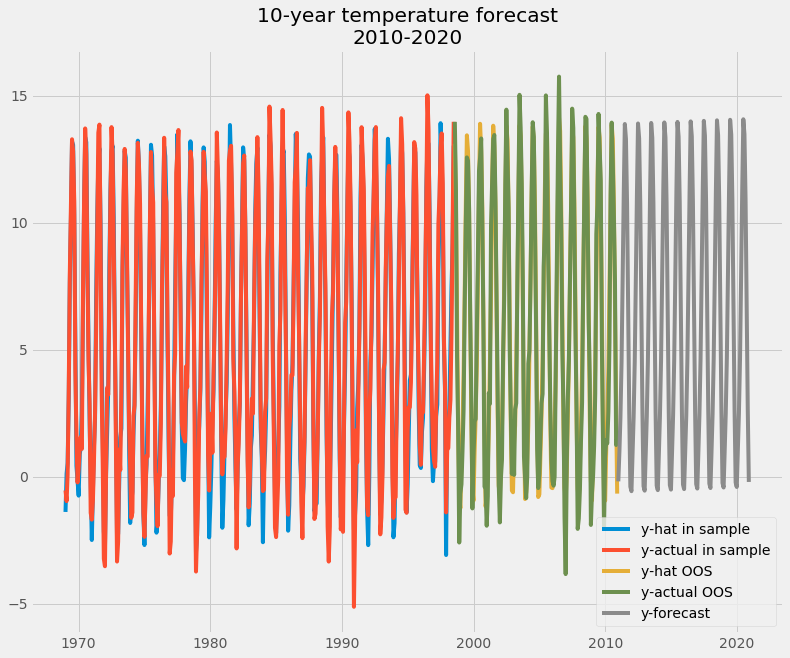

In [141]:
plt.plot(list(nat_f[240:len(y_train)].index), y_hat[240:], label = 'y-hat in sample')
plt.plot(list(nat_f[240:len(y_train)].index), y_train[240:], label = 'y-actual in sample')
plt.plot(list(nat_f[len(y_train):].index),y_pred, label = 'y-hat OOS')
plt.plot(list(nat_f[len(y_train):].index), y_test, label = 'y-actual OOS')
plt.plot(timestamp,Y_fcat,label='y-forecast')

plt.title("10-year temperature forecast\n2010-2020")
plt.legend()
plt.show()

### Forecasting volatility

In [99]:
nat = nat.drop(columns=['precip_vol','wind_vol'])
nat['var'] = (nat['min_temp'] - np.mean(nat['min_temp']) ) ** 2
nat['err'] = nat['min_temp'] - np.mean(nat['min_temp']) 
nat.head(5)

min_temp     precip      wind         var        err
timestamp                                                       
1949-01-01 -8.641026  85.739787  3.610303  167.721974 -12.950752
1949-02-01 -6.053709  61.783811  3.285554  107.400783 -10.363435
1949-03-01 -1.118009  66.410196  3.473792   29.460306  -5.427735
1949-04-01  3.804154  52.978680  3.081735    0.255603  -0.505572
1949-05-01  9.142443  71.157806  2.843492   23.355157   4.832717

We then split the data set into train and test sets

In [100]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(nat,
                                   test_size=0.2,
                                   shuffle=False,
                                   random_state=42)

ADF Statistic: -6.042254
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569

We reject the Null Hypothesis (H0) -- the time series is stationary


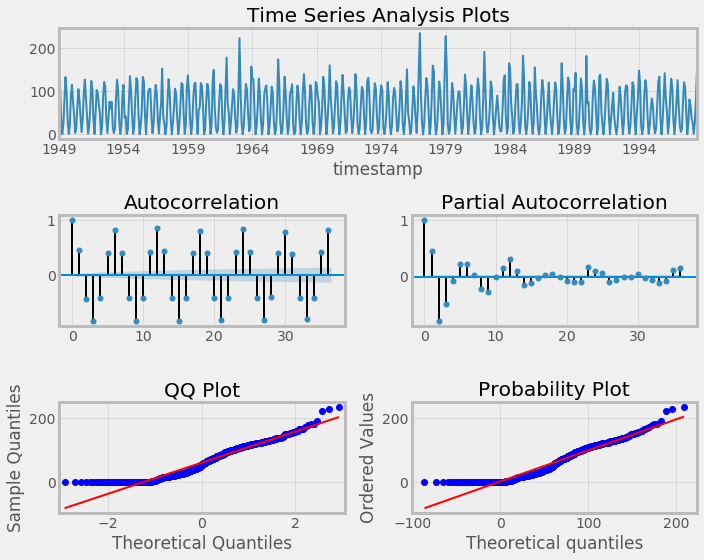

In [101]:
testing.ts_plot(y_train['var'],lags=36)

Ljung-Box diagnosis

In [102]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox

lb, p_values=ljungbox(y_train['var'], lags=24)

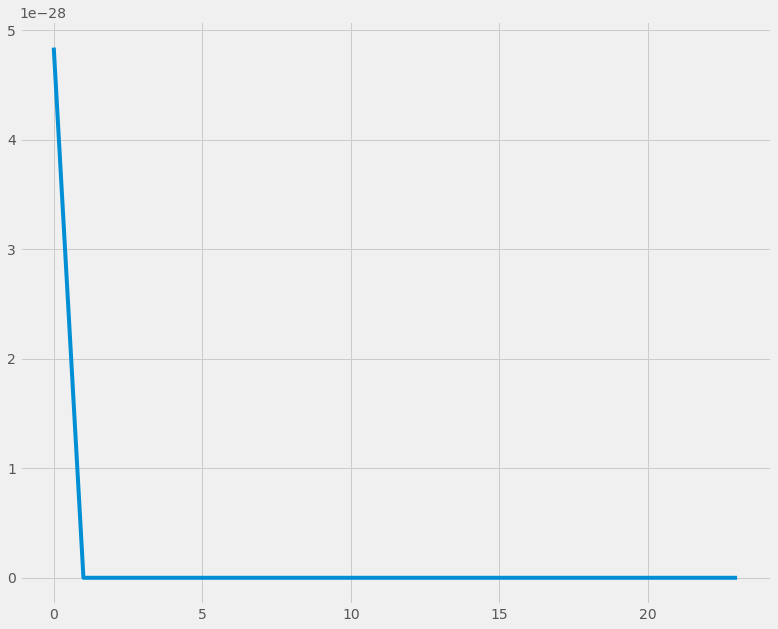

[4.83913811e-028 2.10602863e-050 1.59007167e-140 6.63928810e-162
 4.26004181e-182 6.33926432e-267 3.80300552e-287 1.58170622e-308
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]


In [103]:
plt.plot(p_values)
plt.show()
print(p_values)

The low p-values of the Ljung-Box test suggest there is auto-correlation left in the residuals

### ARCH Forecast

In [104]:
from arch import arch_model

model = arch_model(y_train['min_temp'], mean='Constant', vol='ARCH',dist='gaussian',p=1)
f_arch = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2047.088983985473
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2047.060993791131
Iteration:      3,   Func. Count:     18,   Neg. LLF: 2047.0022880103038
Iteration:      4,   Func. Count:     23,   Neg. LLF: 2047.0007565392073
Iteration:      5,   Func. Count:     28,   Neg. LLF: 2046.9944056869183
Iteration:      6,   Func. Count:     33,   Neg. LLF: 2046.9904628431327
Iteration:      7,   Func. Count:     38,   Neg. LLF: 2046.990457386424
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2046.9904573864942
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7


In [105]:
f_arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:               min_temp   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -2046.99
Distribution:                  Normal   AIC:                           4099.98
Method:            Maximum Likelihood   BIC:                           4113.15
                                        No. Observations:                  595
Date:                Thu, Dec 05 2019   Df Residuals:                      592
Time:                        20:08:23   Df Model:                            3
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             3.9484      1.246      3.168  1.533e-03 [  1.506,  6.391]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         30.0815      2.235     13.457  2.809e-41 [ 25.700, 34.463]
alpha[1]       0.5221  4.101e-02     12.731  3.979e-37 [  0.442,  0.603]
========================================================================

Covariance estimator: robust
"""

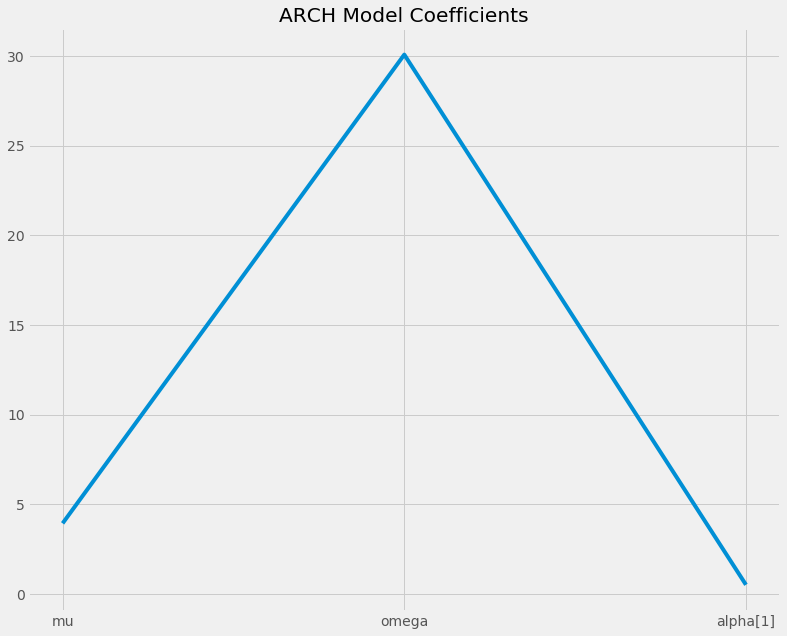

In [106]:
plt.plot(f_arch.params)
plt.title('ARCH Model Coefficients')
plt.show()

In [107]:
H = y_train['min_temp'].tolist()
Y = []
Y_hat = []

for r in y_test['min_temp'].tolist():
    model = arch_model(H, mean='Constant', vol='ARCH',dist='gaussian',p=12)
    f_arch = model.fit(disp='off', show_warning=False)
    
    y = (r - np.mean(H)) ** 2
    Y += [y]
    
    fc = f_arch.forecast(horizon=2)
    y_hat = fc.variance.values[-1,:][0]
    Y_hat += [y_hat]
    
    H += [r]
    H.pop(0)

In [108]:
P_ARCH = Y_hat

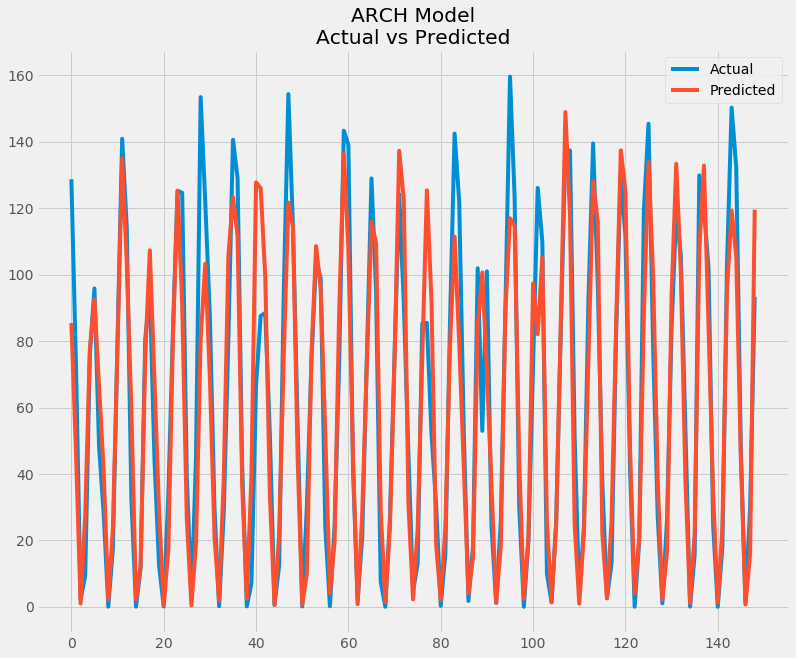

In [109]:
plt.plot(Y, label='Actual')
plt.plot(Y_hat, label='Predicted')
plt.legend()
plt.title('ARCH Model\nActual vs Predicted')
plt.show()

In [110]:
vol_in = {}

vol_in['ARCH'] = testing.measure_error(y_train['var'][1:], f_arch.conditional_volatility[1:], label='ARCH in-sample',show=False)

### GARCH Model

In [111]:
model = arch_model(y_train['min_temp'], mean='Constant', vol='GARCH',dist='gaussian',p=12, q=1)
f_garch = model.fit()

Iteration:      1,   Func. Count:     17,   Neg. LLF: 2068.96625746671
Iteration:      2,   Func. Count:     35,   Neg. LLF: 2036.0580965646764
Iteration:      3,   Func. Count:     52,   Neg. LLF: 1971.9318701377474
Iteration:      4,   Func. Count:     70,   Neg. LLF: 1970.4724919221906
Iteration:      5,   Func. Count:     87,   Neg. LLF: 1961.9268960426134
Iteration:      6,   Func. Count:    105,   Neg. LLF: 1955.072981849319
Iteration:      7,   Func. Count:    123,   Neg. LLF: 1943.1624395926337
Iteration:      8,   Func. Count:    142,   Neg. LLF: 1941.4697816386702
Iteration:      9,   Func. Count:    160,   Neg. LLF: 1937.3553728682068
Iteration:     10,   Func. Count:    178,   Neg. LLF: 1932.3691176477028
Iteration:     11,   Func. Count:    196,   Neg. LLF: 1926.8053647551526
Iteration:     12,   Func. Count:    213,   Neg. LLF: 1899.651336942984
Iteration:     13,   Func. Count:    232,   Neg. LLF: 1897.7741934894043
Iteration:     14,   Func. Count:    250,   Neg. LLF: 1

In [112]:
f_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               min_temp   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1880.73
Distribution:                  Normal   AIC:                           3791.45
Method:            Maximum Likelihood   BIC:                           3857.28
                                        No. Observations:                  595
Date:                Thu, Dec 05 2019   Df Residuals:                      580
Time:                        20:08:58   Df Model:                           15
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             4.0767      0.255     16.000  1.272e-57 [  3.577,  4.576]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.2474e-16      2.281  5.469e-17      1.000      [ -4.470,  4.470]
alpha[1]   1.7117e-11  7.330e-02  2.335e-10      1.000      [ -0.144,  0.144]
alpha[2]   1.3047e-10  8.321e-02  1.568e-09      1.000      [ -0.163,  0.163]
alpha[3]   9.3299e-11  4.100e-02  2.275e-09      1.000 [-8.037e-02,8.037e-02]
alpha[4]   1.2008e-10  3.824e-02  3.140e-09      1.000 [-7.496e-02,7.496e-02]
alpha[5]   1.9496e-15  4.254e-02  4.583e-14      1.000 [-8.337e-02,8.337e-02]
alpha[6]       0.3404      0.203      1.679  9.316e-02   [-5.697e-02,  0.738]
alpha[7]   3.1728e-15  5.228e-02  6.069e-14      1.000      [ -0.102,  0.102]
alpha[8]   1.1203e-10  2.911e-02  3.848e-09      1.000 [-5.706e-02,5.706e-02]
alpha[9]   2.0665e-03  1.143e-02      0.181      0.856 [-2.033e-02,2.446e-02]
alpha[10]  9.0887e-11  8.484e-03  1.071e-08      1.000 [-1.663e-02,1.663e-02]
alpha[11]      0.0125  1.811e-02      0.692      0.489 [-2.296e-02,4.801e-02]
alpha[12]      0.6426      0.251      2.557  1.054e-02      [  0.150,  1.135]
beta[1]    2.1778e-15  7.173e-02  3.036e-14      1.000      [ -0.141,  0.141]
=============================================================================

Covariance estimator: robust
"""

In [113]:
H = y_train['min_temp'].tolist()
Y = []
Y_hat = []

for r in y_test['min_temp'].tolist():
    model = arch_model(H, mean='Constant', vol='GARCH',dist='gaussian',p=12,q=1)
    f_arch = model.fit(disp='off', show_warning=False)
    
    y = (r - np.mean(H)) ** 2
    Y += [y]
    
    fc = f_arch.forecast(horizon=1)
    y_hat = fc.variance.values[-1,:][0]
    Y_hat += [y_hat]
    
    H += [r]
    H.pop(0)

In [114]:
P_GARCH = Y_hat

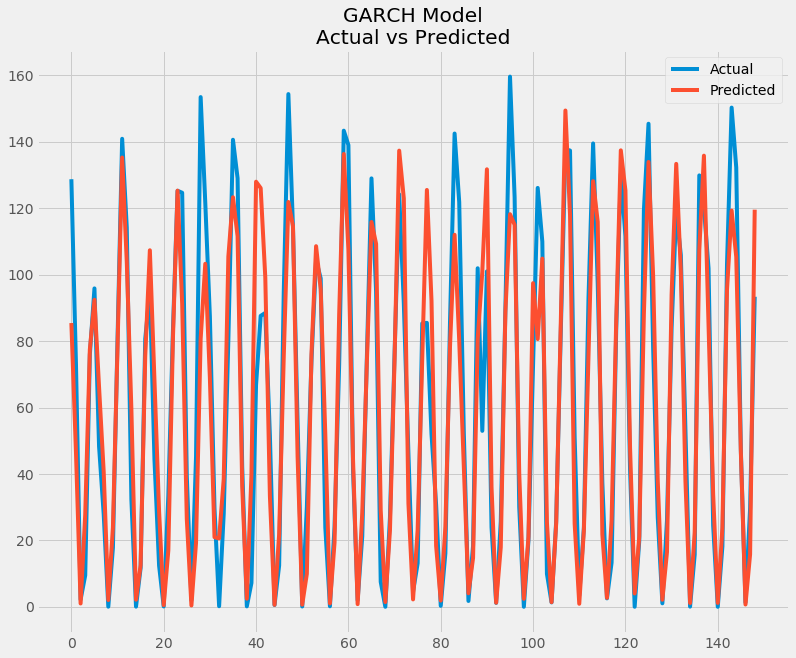

In [115]:
plt.plot(Y, label='Actual')
plt.plot(Y_hat, label='Predicted')
plt.legend()
plt.title('GARCH Model\nActual vs Predicted')
plt.show()

In [116]:
vol_in['GARCH'] = testing.measure_error(y_train['var'], f_garch.conditional_volatility, label='GARCH in-sample',show=False)

#### Comparing volatility models

-----
ARCH
-----
+------------+---------------------+
|   metric   |        value        |
+------------+---------------------+
|   label    |       ARCH OOS      |
|    RMSE    |  18.70450798589656  |
| RMSE_pcent | 0.30115985057118316 |
+------------+---------------------+
-----
GARCH
-----
+------------+--------------------+
|   metric   |       value        |
+------------+--------------------+
|   label    |     GARCH OOS      |
|    RMSE    | 18.803184880409848 |
| RMSE_pcent | 0.3027486396924398 |
+------------+--------------------+


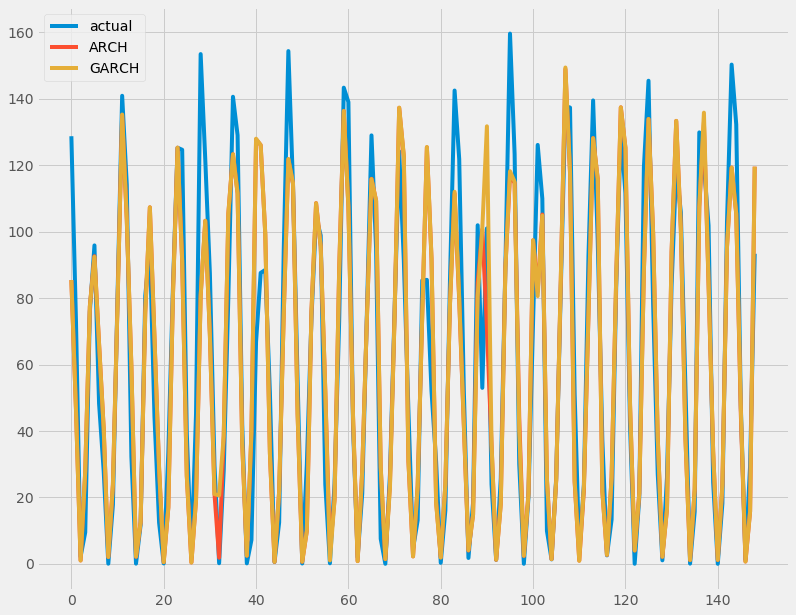

In [117]:
lst = [('ARCH', P_ARCH),
       ('GARCH', P_GARCH)]
plt.plot(Y, label='actual')
vol_out = {}
for (lab, Y_hat) in lst:
    print('-----\n%s\n-----' % lab)
    vol_out[lab] = testing.measure_error(Y, Y_hat,label=lab+' OOS')
    plt.plot(Y_hat, label=lab)
plt.legend()
plt.show()

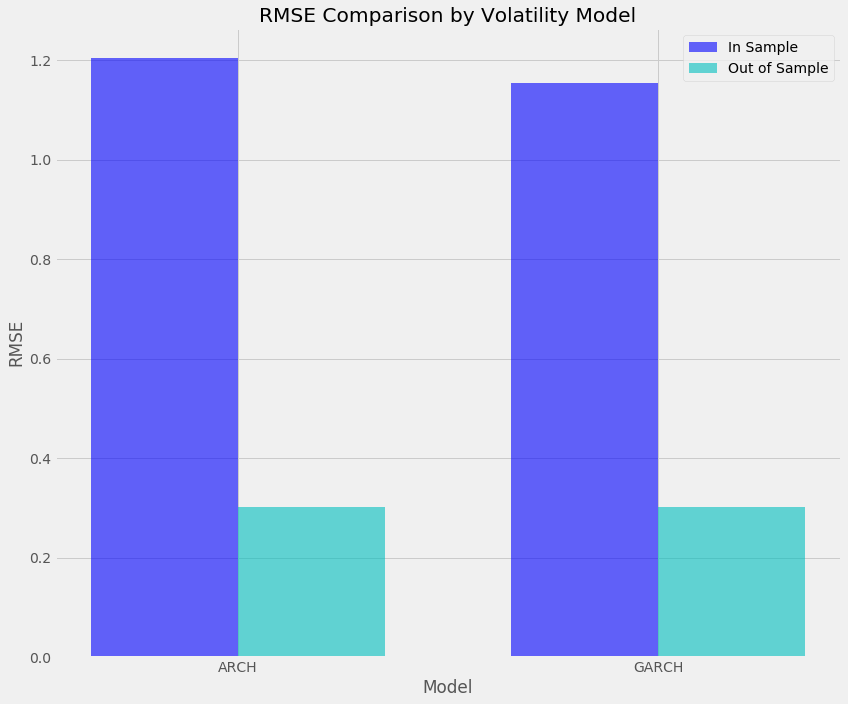

In [118]:
'''
Adapted from https://pythonspot.com/matplotlib-bar-chart/
'''
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.35
opacity = 0.6

in_sample = (vol_in['ARCH']['RMSE_pcent'],
             vol_in['GARCH']['RMSE_pcent'])
out_sample = (vol_out['ARCH']['RMSE_pcent'],
             vol_out['GARCH']['RMSE_pcent'])

rects1 = plt.bar(index, in_sample, bar_width,
                alpha=opacity,
                color='b',
                label='In Sample')

rects2 = plt.bar(index + bar_width, out_sample, bar_width,
                alpha=opacity,
                color='c',
                label='Out of Sample')

plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison by Volatility Model')
plt.xticks(index + (bar_width/2), ('ARCH','GARCH'))
plt.legend()

plt.tight_layout()
plt.show()

### FORECASTING VOLATILITY

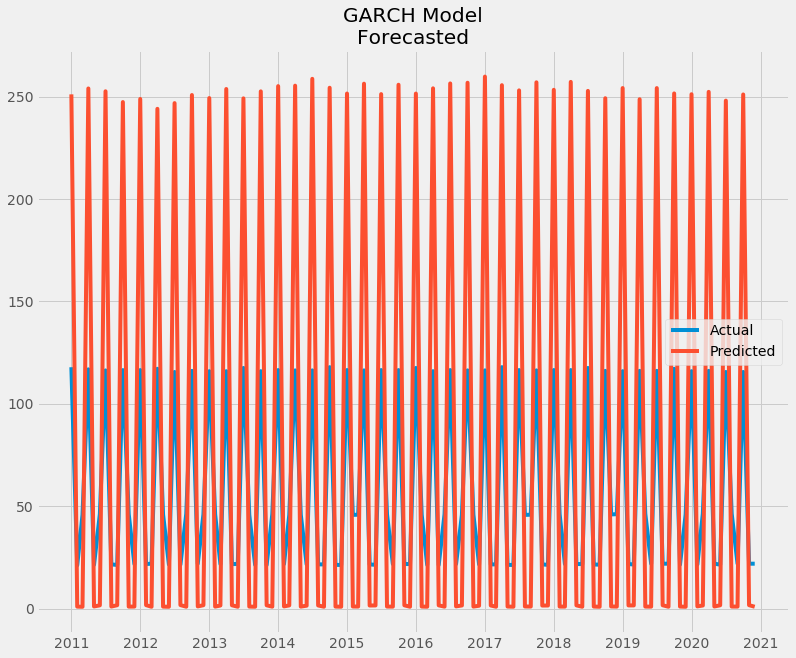

In [133]:
H = Y_fcat
Y = []
Y_hat = []

for r in H:
    model = arch_model(H, mean='Constant', vol='GARCH',dist='gaussian',p=12,q=1)
    f_arch = model.fit(disp='off', show_warning=False)
    
    y = (r - np.mean(H)) ** 2
    Y += [y]
    
    fc = f_arch.forecast(horizon=1)
    y_hat = fc.variance.values[-1,:][0]
    Y_hat += [y_hat]
    
    H += [r]
    H.pop(0)

plt.plot(timestamp, Y, label='Actual')
plt.plot(timestamp, Y_hat, label='Predicted')
plt.legend()
plt.title('GARCH Model\nForecasted')
plt.show()